In [1]:
# Example - https://github.com/cornelliusyudhawijaya/Churn_Causality_Analysis/blob/main/Causal%20Analysis%20Do%20Why.ipynb
    
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets 

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings('ignore')

# Prepare Data

In [2]:
data = pd.read_csv('../../../data/Titanic.csv')

## Drop categorical features
data = data.drop(['Name','Ticket','Cabin','PassengerId','Embarked'],axis=1)

## Drop NULL values
data = data.dropna()

## Drop NULL values
data = data.fillna(0)

## Change symbolics to numerics
data['sex'] = np.where(data['sex'] == 'male', 0, 1)

protected_attribute = 'sex'

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data),columns = data.columns)
print(data.head(5))

   Pclass  sex       Age  SibSp  Parch      Fare  Probability
0     1.0  0.0  0.271174    0.2    0.0  0.014151          0.0
1     0.0  1.0  0.472229    0.2    0.0  0.139136          1.0
2     1.0  1.0  0.321438    0.0    0.0  0.015469          1.0
3     0.0  1.0  0.434531    0.2    0.0  0.103644          1.0
4     1.0  0.0  0.434531    0.0    0.0  0.015713          0.0


In [3]:
# This dataset size is very small. So repeating it to make it bigger

dataset_orig = pd.concat([data]*5, ignore_index=True)

# Transform data using LFR

In [4]:
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.datasets import BinaryLabelDataset
from IPython.display import Markdown, display
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
dataset_orig = data.copy()
protected_attribute = "sex"
dataset_orig_train, dataset_orig_test = train_test_split(dataset_orig, test_size=0.2,random_state=0)
privileged_groups = [{protected_attribute: 1}]
unprivileged_groups = [{protected_attribute: 0}]

TR = LFR(unprivileged_groups=unprivileged_groups,
         privileged_groups=privileged_groups,
         k=10, Ax=0.1, Ay=1.0, Az=2.0,
         verbose=1)

dataset_orig_train = BinaryLabelDataset(df=dataset_orig_train, label_names=['Probability'], protected_attribute_names=[protected_attribute])

TR.fit(dataset_orig_train, maxiter=5000, maxfun=5000)

dataset_transf = TR.transform(dataset_orig_train)
dataset_orig_train, yy = dataset_transf.convert_to_dataframe()

from sklearn.linear_model import LogisticRegression
from Measure import measure_final_score,calculate_recall,calculate_far,calculate_precision,calculate_accuracy

X_train, y_train =  dataset_orig_train.loc[:, dataset_orig_train.columns != 'Probability'], dataset_orig_train['Probability']
X_test, y_test = dataset_orig_test.loc[:, dataset_orig_test.columns != 'Probability'], dataset_orig_test['Probability']
        
clf = LogisticRegression(C=1.0, penalty='l2', solver='liblinear', max_iter=100) # LSR
clf.fit(X_train,y_train)

print("aod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'aod'))
print("eod :"+protected_attribute,measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'eod'))
print("SPD:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'SPD'))
print("DI:",measure_final_score(dataset_orig_test, clf, X_train, y_train, X_test, y_test, protected_attribute, 'DI'))

step: 0, loss: 0.771980287458706, L_x: 0.3383994960341745,  L_y: 0.6974961554722436,  L_z: 0.020322091191522444
step: 250, loss: 0.7075232910031594, L_x: 0.322016134560712,  L_y: 0.6422523591588661,  L_z: 0.016534659194111033
step: 500, loss: 0.6709420098712667, L_x: 0.11196411684992899,  L_y: 0.6030531086450261,  L_z: 0.028346244770623873
step: 750, loss: 0.6412928645038942, L_x: 0.09805155950660943,  L_y: 0.5494593918561853,  L_z: 0.041014158348524
step: 1000, loss: 0.631099096876308, L_x: 0.0995266438946525,  L_y: 0.5555495597186838,  L_z: 0.03279843638407948
step: 1250, loss: 0.6296020384287991, L_x: 0.094164501352824,  L_y: 0.5521706297998473,  L_z: 0.03400747924683474
step: 1500, loss: 0.6273758641557947, L_x: 0.09604435194730168,  L_y: 0.5581317463948379,  L_z: 0.029819841283113324
step: 1750, loss: 0.6258060853396442, L_x: 0.09413739336771308,  L_y: 0.5571932036071511,  L_z: 0.029599571197860875
step: 2000, loss: 0.6259558695327674, L_x: 0.09401673533844786,  L_y: 0.55722838782

# Graph

In [31]:
causal_graph = """
digraph {
Age;
sex;
Fare;
Probability;
U[label="Unobserved Confounders"];

Age -> Probability;
sex -> Probability;
Age -> fare; sex -> Fare; Fare -> Probability;
U->sex;U->Probability;
}
"""

## dowhy works for binary inputs only
dataset_orig_train['Probability'] = np.where(dataset_orig_train['Probability'] == 0, False, True)
dataset_orig_train[protected_attribute] = np.where(dataset_orig_train[protected_attribute] == 1, True, False)

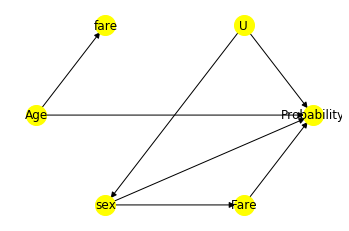

In [32]:
# With graph
model=CausalModel(
        data = dataset_orig_train,
        treatment=protected_attribute,
        outcome="Probability",
        graph=causal_graph.replace("\n", " ")
        )
model.view_model()

In [33]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|Age))
d[sex]                              
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,Age,U) = P(Probability|sex,Age)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



In [34]:
causal_estimate = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print("Causal Estimate is " + str(causal_estimate.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
──────(Expectation(Probability|Age))
d[sex]                              
Estimand assumption 1, Unconfoundedness: If U→{sex} and U→Probability then P(Probability|sex,Age,U) = P(Probability|sex,Age)

## Realized estimand
b: Probability~sex+Age
Target units: ate

## Estimate
Mean value: 0.5634518535404335

Causal Estimate is 0.5634518535404335


In [ ]:
# Causal effect on the control group (ATC)
causal_estimate_att = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification",
        target_units = "atc")
print(causal_estimate_att)
print("Causal Estimate is " + str(causal_estimate_att.value))

# Add Random Common Cause

In [11]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "random_common_cause")
print(refutel)

Refute: Add a Random Common Cause
Estimated effect:0.22915209790209792
New effect:0.208168816240213



# Replace Treatment with Placebo

In [12]:
refutel = model.refute_estimate(identified_estimand,causal_estimate,method_name="placebo_treatment_refuter",placebo_type="permute")
print(refutel)

Refute: Use a Placebo Treatment
Estimated effect:0.22915209790209792
New effect:0.00037596917488207337
p value:0.45



# Remove Random Subset of Data

In [13]:
refutel = model.refute_estimate(identified_estimand,causal_estimate, "data_subset_refuter")
print(refutel)

Refute: Use a subset of data
Estimated effect:0.22915209790209792
New effect:0.22374185763198182
p value:0.38

